# Beginning of Exploratory Data Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')
from demyst.analytics import Analytics
analytics = Analytics(username="code-challenge-johnathan@demystdata.com", password="y(z%CrM32aXW^CQw8cUe2Mx83uG[")
import joblib
import numpy as np
import os
import pandas as pd
df = pd.read_csv('input_file.csv', encoding = "latin", header=0)
df_copy = df.copy()
print(df_copy.shape)
analytics.validate(df_copy)


(11229, 5)


Column,Status,Description
street,All Valid,All values in this column are good to go.
state,Some Invalid,16.8% of the values of this column failed validation. One example of an invalid value is 'NJ '. Click here for documentation for this column.
city,All Valid,All values in this column are good to go.
postcode,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.
safety_flag,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.


The two columns 'postcode' and 'safety_flag' aren't recognised as valid column names.
We're able to infer the valid column names from https://demyst.com/docs/demyst-live/types/.

Based on the column names found in the link listed avoce, we need to change the column name 'postcode' to 'post-code'.
'safety_flag' is also not recognised as a valid name, but we can leave it in the dataframe for now because that is our 'target' variable.
We will also need to fix the 'state' variables as there are invalid data points present as shown in the output above.

In [431]:
df_copy.rename(index=str, columns={"postcode": "post_code"}, inplace=True)
analytics.validate(df_copy)


Column,Status,Description
street,All Valid,All values in this column are good to go.
state,Some Invalid,16.8% of the values of this column failed validation. One example of an invalid value is 'NJ '. Click here for documentation for this column.
city,All Valid,All values in this column are good to go.
post_code,Some Invalid,0.1% of the values of this column failed validation. One example of an invalid value is 'nan'. Click here for documentation for this column.
safety_flag,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.


<!-- The column that has name 'safety_flag' has been inferred to be of type 'Boolean'. This is useful to know - even though we can't use this column for a lookup search for data enrichment, the DemystData api is at least able to infer the *type* of this target variable. -->
Now that we've changed the name of 'postcode' to a valid column name (post-code), the analysis recognises this column and has shown that there is a small proportion (0.1%) of invalid data, including the presence of 'nans'.
Likewise, the 'state' variable contains invalid data, so we need to fix those invalid data points additionally.

### Clean data that has invalid inputs

There are 'nans' present in the 'state' and 'post_code' variables, so we will drop those from the dataframe

In [432]:
df_copy.isna().sum()

street         0
state          9
city           9
post_code      9
safety_flag    0
dtype: int64

In [433]:
print(df_copy.shape)
# this will drop *all* 'nans', regardless of which variable is contained
df_copy.dropna(inplace=True)
print(df_copy.shape)

(11229, 5)
(11219, 5)


We managed to remove 10 records from the input data after executing the 'dropna' function, in an 'inplace' manner

In [434]:
print(df_copy['state'].unique())

['FL' 'IN' 'VA' 'OH' 'MA' 'MN' 'WI' 'NC' 'CO' 'CA' 'NY' 'NH' 'CT' 'MD'
 'NJ' 'KY' 'WA' 'IA' 'LA' 'GA' 'IL' 'TX' 'AZ' 'DE' 'MI' 'RI' 'OR' 'AR'
 'HI' 'PA' 'SC' 'AL' 'TN' 'WY' 'NV' 'NE' 'MT' 'MS' 'OK' 'KS' 'MO' 'ID'
 'DC' 'UT' 'NM' 'ND' 'ME' 'VT' 'AK' 'SD' 'NJ  ' 'NY  ' 'CA  ' 'OR  '
 'GA  ' 'MI  ' 'AZ  ' 'TX  ' 'PA  ']


There is whitespace present in several of the data points, so we should remove them

In [435]:
# remove whitespace found in state names above
df_copy['state'] = df_copy['state'].str.strip()

There is an inconsistent schema for the 'city' variable as seen below ('VACKAVILLE' vs 'Lakeland')

In [436]:
df_copy['city'].unique()

array(['Lakeland', 'Indianapolis', 'Troutville', ..., 'VACKAVILLE',
       'San Juan Capistrano', 'White Pains'], dtype=object)

In [437]:
df_copy['city'].value_counts()

New York            245
Brooklyn            158
San Francisco       155
Los Angeles         138
Chicago              99
San Antonio          83
San Diego            83
Houston              82
San Jose             74
Bronx                65
Dallas               54
Miami                50
Atlanta              43
Philadelphia         43
Sacramento           42
Oakland              41
Austin               37
Orlando              37
Charlotte            34
Seattle              33
Phoenix              32
Jacksonville         31
El Paso              31
Las Vegas            30
Washington           27
Fort Worth           27
Long Beach           26
Portland             25
Fresno               25
Pittsburgh           25
                   ... 
Sandy Hook            1
Ambridge              1
Burney                1
Pembroke pines        1
Flanders              1
Beloit                1
king of prussia       1
North Tonawanda       1
greeley               1
fox lake              1
Gowen           


Because the majority of city names conform to the schema with a capitalised first letter for each part of the name,
we need to transform other data points (such as 'long beach' and 'VACKAVILLE') to a schema like:
'Long Beach', and 'Vackaville'

In [438]:
df_copy['city'] = df_copy['city'].str.title()


In [439]:
df_copy['city'].value_counts()

New York             261
Brooklyn             167
San Francisco        158
Los Angeles          142
Chicago              104
San Diego             88
San Antonio           85
Houston               84
San Jose              76
Bronx                 73
Miami                 54
Dallas                54
Sacramento            45
Philadelphia          43
Atlanta               43
Oakland               43
Austin                39
Orlando               37
Charlotte             36
Las Vegas             35
Seattle               35
Jacksonville          33
Phoenix               32
El Paso               32
Washington            30
Long Beach            29
Fort Worth            29
Albany                26
Pittsburgh            26
Portland              26
                    ... 
Chichester             1
Moorhead               1
Chantilly              1
Callicoon              1
Gleason                1
Lock Haven             1
Havertown              1
Minooka                1
Burien                 1


As seen above, now the 'state' variable contains data points that all conform to the same schema

Based on the 'postcode' output below, there are variable types of coding schemas present in the dataset.
We need to ensure that each postcode is of fixed length. 

In [440]:
df_copy['post_code'].unique()

array(['33812-5237', '46227', '24175-6054', ..., '14626', '92192',
       '92782'], dtype=object)

The majority of postcodes are 5 digits long, so let's ensure that *every* postcode is of that length

In [441]:
df_copy['post_code'].value_counts().head(6)

94107    25
94103    21
10001    20
10016    16
10003    14
10012    13
Name: post_code, dtype: int64

In [442]:
# we need to ensure we have a consistent schema for the postcodes
def transform_postcodes(pc):
    '''Takes in a list/pd.series of postcodes and transforms each to be length of five digits.'''
    max_len = len(pc)
    # fill them with a zero 
    if max_len == 4:
        return pc.zfill(5)
    # this is the optimal length of the post-code, so we can return as is
    if max_len == 5:
        return pc
    # if the post-code is longer than 5 digits, just return just the first five digits 
    else:
        return pc[:5]


In [443]:
a = df_copy['post_code'].astype('str').apply(transform_postcodes)
a.value_counts()

94107    26
94103    22
10001    22
10016    17
10003    15
10012    13
11201    13
10019    13
11222    13
10022    12
94110    12
10013    12
10014    11
94025    11
10018    11
90069    11
92101    10
94111    10
94610    10
10010    10
92660    10
94114    10
12866    10
94109    10
11249    10
07024    10
92130     9
94105     9
10009     9
11215     9
         ..
55358     1
80751     1
11553     1
92240     1
29303     1
29172     1
51201     1
02330     1
85305     1
66772     1
93304     1
50249     1
01082     1
31058     1
37821     1
98591     1
13057     1
21046     1
15235     1
19522     1
62223     1
39038     1
78404     1
66537     1
99362     1
55396     1
32177     1
17551     1
60051     1
95124     1
Name: post_code, Length: 6597, dtype: int64

Now we're ready to apply the 'transform_postcodes' function to the 'post_code' variable

In [444]:
df_copy['post_code'] = df_copy['post_code'].astype('str').apply(transform_postcodes)


In [445]:
analytics.validate(df_copy)


Column,Status,Description
street,All Valid,All values in this column are good to go.
state,All Valid,All values in this column are good to go.
city,All Valid,All values in this column are good to go.
post_code,All Valid,All values in this column are good to go.
safety_flag,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.


Everything appears 'good to go' for data enrichment *however*, we also need to ensure that there aren't any duplicated data points present.    


In [446]:
df_copy[df_copy.duplicated()].shape[0]

21

21 duplicates were found, so let's drop them

In [447]:
df_copy.drop_duplicates(inplace=True)


Now we're ready to search for any data sets that we could use for enrichment for our input data

In [448]:
analytics.search(df_copy)


,post_code,street,country,city,state
Option 1,☒,☒,☐,☒,☒


The above output shows that 'attom_expanded_profile_report' could be used to enrich our input dataframe.
However, we don't have the column/attribute 'country' present in our data, so we need to include that to get a proper match.
We can infer that the 'country' column can be set to 'US', as the output from running df['state'].unique() shows that each of the two letter acronyms match the 'ISO_3166-1_alpha-2' schema referenced in https://demyst.com/docs/demyst-live/types/#country
So let's add that column to the sanitised dataframe.


In [449]:
df_copy['country'] = 'US'


In [450]:
analytics.search(df_copy)


,post_code,street,country,city,state
Option 1,☒,☒,☒,☒,☒


Now all the data matches!
It's time to perform enrichment and downloading

In [503]:
analytics.validate(df_copy)

Column,Status,Description
street,All Valid,All values in this column are good to go.
state,All Valid,All values in this column are good to go.
city,All Valid,All values in this column are good to go.
post_code,All Valid,All values in this column are good to go.
safety_flag,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.
country,All Valid,All values in this column are good to go.


In [47]:
# check if enriched data already exists, otherwise write it out to a csv file
if not os.path.isfile('enriched_dataframe_attom.csv'):
    results = analytics.enrich_and_download(["attom_expanded_profile_report"], df_copy, validate=True)
    results.to_csv('enriched_dataframe_attom.csv', index=False)


Verifying providers...
Starting enrichment...
Enrich Job ID: 13191


IntProgress(value=1, max=2)

HTML(value='Checking status...')

The output of the below cell shows that we've obtained four new columns appended to our original data

In [451]:
# after reading in the enriched data from a csv, we need to drop useless columns like 'Unnamed: 0'
results = pd.read_csv('enriched_dataframe_attom.csv')
results.drop(results.filter(regex="Unname|index"),axis=1, inplace=True)
results.head(3)

,inputs.city,inputs.country,inputs.post_code,inputs.safety_flag,inputs.state,inputs.street,attom_expanded_profile_report.row_id,attom_expanded_profile_report.client_id,attom_expanded_profile_report.attom_id,attom_expanded_profile_report.error
0,Lakeland,USA,33812,False,FL,3160 Otto Dr,0,NaN,162278089.0,NaN
1,Indianapolis,USA,46227,False,IN,940 Tulip Dr,1,NaN,28461481.0,NaN
2,Troutville,USA,24175,False,VA,68 Rocky Top Rd,2,NaN,214628965.0,NaN


In [452]:
results.shape

(11198, 10)

In [169]:
# comparison of enriched datadframe with original data
from IPython.display import display
display(df_copy.head(5))
display(results.head(5))
display(df_copy.shape)
display(results.shape)

,street,state,city,post_code,safety_flag,country
0,3160 Otto Dr,FL,Lakeland,33812,False,US
1,940 Tulip Dr,IN,Indianapolis,46227,False,US
2,68 Rocky Top Rd,VA,Troutville,24175,False,US
3,3330 Taylor Blair Rd,OH,West Jefferson,43162,False,US
4,4254 Eagle Landing Parkway,FL,Orange Park,32065,False,US


,inputs.city,inputs.country,inputs.post_code,inputs.safety_flag,inputs.state,inputs.street,attom_expanded_profile_report.row_id,attom_expanded_profile_report.client_id,attom_expanded_profile_report.attom_id,attom_expanded_profile_report.error
0,Lakeland,USA,33812,False,FL,3160 Otto Dr,0,NaN,162278089.0,NaN
1,Indianapolis,USA,46227,False,IN,940 Tulip Dr,1,NaN,28461481.0,NaN
2,Troutville,USA,24175,False,VA,68 Rocky Top Rd,2,NaN,214628965.0,NaN
3,West Jefferson,USA,43162,False,OH,3330 Taylor Blair Rd,3,NaN,246515148.0,NaN
4,Orange Park,USA,32065,False,FL,4254 Eagle Landing Parkway,4,NaN,164680663.0,NaN


(11198, 6)

(11198, 10)

Let's save the results to csv for future use...

Let's do some analysis on the new data to see if there is any cleaning required.

In [453]:
results['attom_expanded_profile_report.attom_id'] = results['attom_expanded_profile_report.attom_id'].astype(str)
display(results['attom_expanded_profile_report.attom_id'].min())
display(results['attom_expanded_profile_report.attom_id'].max())
display(type(results['attom_expanded_profile_report.attom_id'].iloc[0]))

'100013224.0'

'nan'

str

Let's find the indices of the empty values

In [454]:
empty_res_idxs = results['attom_expanded_profile_report.attom_id'][results['attom_expanded_profile_report.attom_id'].isin(['nan'])].index

In [455]:
empty_res_idxs

Int64Index([   15,    25,    32,    35,    46,    69,    76,    78,    82,
               87,
            ...
            11169, 11171, 11173, 11178, 11180, 11184, 11186, 11187, 11190,
            11195],
           dtype='int64', length=2294)

Let's replace those empty atom ids with 'nans'

In [456]:
results['attom_expanded_profile_report.attom_id'].iloc[empty_res_idxs] = results['attom_expanded_profile_report.attom_id'].iloc[empty_res_idxs].replace('', np.nan)

Now we have to drop 2294 of these records with empty atom ids

In [457]:
results['attom_expanded_profile_report.attom_id'].value_counts()

nan            2294
155661423.0       4
206014472.0       3
157625010.0       3
168314141.0       2
155978117.0       2
155999620.0       2
157172850.0       2
200973617.0       2
224674708.0       2
216044453.0       2
206551040.0       2
169559254.0       2
168655763.0       2
46343898.0        2
162850659.0       2
51309196.0        2
45608305.0        2
170838616.0       2
151113878.0       2
156777902.0       2
223390422.0       2
205710214.0       2
169176504.0       2
169180531.0       2
156158432.0       2
31236220.0        2
156346735.0       2
243763327.0       2
227579808.0       2
               ... 
23260640.0        1
209460331.0       1
20154871.0        1
49454559.0        1
34455770.0        1
45945459.0        1
159161898.0       1
168052774.0       1
154396676.0       1
169548732.0       1
191090737.0       1
46698444.0        1
17158735.0        1
187561483.0       1
196178513.0       1
193253751.0       1
41618418.0        1
195815116.0       1
54427789.0        1


In [458]:
# after reading in the enriched data from a csv, we need to drop useless columns like 'Unnamed: 0'
results = pd.read_csv('enriched_dataframe_attom.csv')
results.drop(results.filter(regex="Unname|index"),axis=1, inplace=True)
display(results.shape)
# drop cols first
results.dropna(how='all', axis=1, inplace=True)
# now drop rows 
results.dropna(inplace=True, axis=0)
display(results.shape)
results.drop_duplicates(inplace=True)
display(results.shape)
# drop row_id (not useful) and 'Unnamed :0' - this is an index 
results.drop(columns=['attom_expanded_profile_report.row_id'], inplace=True)
display(results.shape)

(11198, 10)

(8904, 8)

(8904, 8)

(8904, 7)

In [460]:
results.head(3)

,inputs.city,inputs.country,inputs.post_code,inputs.safety_flag,inputs.state,inputs.street,attom_expanded_profile_report.attom_id
0,Lakeland,USA,33812,False,FL,3160 Otto Dr,162278089.0
1,Indianapolis,USA,46227,False,IN,940 Tulip Dr,28461481.0
2,Troutville,USA,24175,False,VA,68 Rocky Top Rd,214628965.0


We need to remove the 'inputs' beginning of each column as there are no matches currently...

In [461]:
results.columns = results.columns.str.replace('inputs.', '').str.replace('attom_expanded_profile_report.', '')
results['country'] = 'US'

In [462]:
analytics.validate(results)

Column,Status,Description
city,All Valid,All values in this column are good to go.
country,All Valid,All values in this column are good to go.
post_code,Not a String Column,You must convert this column to string type.
safety_flag,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.
state,All Valid,All values in this column are good to go.
street,All Valid,All values in this column are good to go.
attom_id,Not a String Column,You must convert this column to string type.


In [465]:
results1 = results.copy()
results['post_code'] = results['post_code'].astype('str')
results['attom_id'] = results['attom_id'].astype('str')


In [466]:
# let's look at any further data sets for enrichment without using a 'strict' policy
display(analytics.search(results, strict=False))


In [467]:
analytics.product_outputs('safety_flag', all_products=True).sample(10)

,provider_name,attribute,option,type,description
1286,attom_tax_assessor,results[].fencecode,output,String,Indicates the presence and/or type of fence on...
1015,attom_recorder,results[].mortgage2interestrateminfirstchanger...,output,Number,Applies only to adjustable rate loans. The min...
1161,attom_tax_assessor,results[].taxmarketvalueland,output,Number,Market value of the land
1011,attom_recorder,results[].mortgage2documentinforideradjustable...,output,String,Flag to indicate if an adjustable rate rider w...
1054,attom_tax_assessor,results[].parcelnumberprevious,output,String,Previous parcel number assigned to the subject...
1082,attom_tax_assessor,results[].legaltractnumber,output,String,Tract number
471,attom_commercial_tax_assessor,results[].deedowner1namemiddle,output,MiddleName,The first deed owner's middle name of the prop...
1071,attom_tax_assessor,results[].propertylatitude,output,Latitude,The latitude of the property in degrees.
125,attom_commercial_pre_foreclosure,results[].publicationdate,output,Date,The date on which the client's data file was e...
809,attom_recorder,results[].transferinfomultiparcelflag,output,Number,Flag used to indicate a multiple parcel transa...


In [468]:
analytics.product_outputs('safety_flag', all_products=True).provider_name.value_counts()

attom_tax_assessor                       319
attom_commercial_tax_assessor            319
attom_recorder                           239
attom_commercial_recorder                239
attom_pre_foreclosure                    104
attom_commercial_pre_foreclosure         104
powerlytics_lfo2_zipcode_naics4_sales     46
attom_commercial_avm                      11
attom_avm                                 11
attom_expanded_profile_report              1
data-fn--818-demyst-testdf                 1
Name: provider_name, dtype: int64

As we have already enriched our initial data with the 'attom_expanded_profile_report' dataset, we can exclude that from further enrichment.
Let's make a list excluding that data set from further enrichments

In [469]:
potential_products = list(set(analytics.product_outputs('safety_flag', all_products=True).provider_name)-\
                          set(['attom_expanded_profile_report']))

In [470]:
potential_products

['attom_avm',
 'attom_commercial_recorder',
 'data-fn--818-demyst-testdf',
 'attom_tax_assessor',
 'powerlytics_lfo2_zipcode_naics4_sales',
 'attom_commercial_pre_foreclosure',
 'attom_recorder',
 'attom_commercial_avm',
 'attom_commercial_tax_assessor',
 'attom_pre_foreclosure']

In [504]:
analytics.validate(results)

Column,Status,Description
city,All Valid,All values in this column are good to go.
country,All Valid,All values in this column are good to go.
post_code,All Valid,All values in this column are good to go.
safety_flag,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.
state,All Valid,All values in this column are good to go.
street,All Valid,All values in this column are good to go.
attom_id,All Valid,All values in this column are good to go.


In [505]:
# obtain one of the potential products
results_avm = analytics.enrich_and_download(["attom_avm"], results, validate=True)


Verifying providers...
Starting enrichment...
Enrich Job ID: 13220


IntProgress(value=1, max=2)

HTML(value='Checking status...')

In [506]:
if not os.path.isfile('results_avm_21_12.csv'):
    results_avm.to_csv('results_avm_21_12.csv', index=False)


We need to clean the data into the appropriate format, as shown above.
Let's create a function to do so.

In [327]:
def clean_avm(df, target_col):
    df.columns = df.columns.str.replace('inputs.', '').str.replace(str(target_col) + '.', '')
    return df

In [199]:
if not os.path.isfile('results_avm_com.csv'):
    results_avm_com = analytics.enrich_and_download(["attom_commercial_avm"], df_avm, validate=True)
    results_avm_com.to_csv('results_avm_com.csv')

Verifying providers...
Starting enrichment...
Enrich Job ID: 13203


IntProgress(value=1, max=2)

HTML(value='Checking status...')

Based on the number of records that were downloaded through both the 'attom_avm' and 'attom_commerical_avm' data sets,
this shows that the input dataset consists *only* of non-commerial/residential records.
Therefore, we can deduce that we can remove any of the commercial data sets from further enrichment pipelines.

In [200]:
results_avm.shape, results_avm_com.shape

((8904, 20), (8904, 30))

The number of records present in the different 'tax_assesor' data sets also confirm that *only* residential properties
are present in our input dataset

In [160]:
analytics.sample_data('data-fn--818-demyst-testdf',row_limit=5).columns

Provider doesn't have any sample data.


We can infer from the name that 'data-fn--818-demyst-testdf' is not going to be of interest to us.
Based on the other product descriptions, the other remaining 'attom' data sets could be used for enrichment.
The 'powerlytics_lfo2_zipcode_naics4_sales' could be of use, but the output of the cell shown below shows that there isn't an 'attom_id' column to tie in this data set to the others.

In [161]:
s = analytics.sample_data('powerlytics_lfo2_zipcode_naics4_sales', row_limit=5).columns
'attom_id' in s

False

In [201]:
updated_prods = [prod for prod in potential_products if not ('comm' in prod or 'avm' in prod or 'power' in prod \
                                                         or 'data-fn' in prod)]
updated_prods

['attom_tax_assessor', 'attom_recorder', 'attom_pre_foreclosure']

In [353]:
results.isna().sum()

city           0
country        0
post_code      0
safety_flag    0
state          0
street         0
attom_id       0
dtype: int64

In [501]:
results['attom_id'] = results['attom_id'].astype(float)
results['attom_id'] = results['attom_id'].astype(int)
results['attom_id'] = results['attom_id'].astype(str)


In [544]:
updated_prods

['attom_tax_assessor', 'attom_recorder', 'attom_pre_foreclosure']

In [546]:
analytics.validate(results)

Column,Status,Description
city,All Valid,All values in this column are good to go.
country,All Valid,All values in this column are good to go.
post_code,All Valid,All values in this column are good to go.
safety_flag,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.
state,All Valid,All values in this column are good to go.
street,All Valid,All values in this column are good to go.
attom_id,All Valid,All values in this column are good to go.


Nowe we can iterate through the remaining product list, and create a 'dict' containing additional meta-data found that
matches our sanitised 'results' dataframe.
We can then concatenate these other results with the earlier downloaded 'recorder_df'.

In [547]:
prod_dict_3 = {}
for idx, prod in enumerate(updated_prods):
    if prod_dict_3.get(str(idx)) is None and not os.path.isfile(f'{prod}_{idx}_22_11.csv'):
        prod_dict_3[str(idx)] = analytics.enrich_and_download([prod], results, validate=True)
        if not os.path.isfile(f'{prod}_{idx}_22_11.csv'):
            prod_dict_2[str(idx)].to_csv(f'{prod}_{idx}_22_11.csv', index=False)
    else:
        prod_dict_3[str(idx)] = pd.read_csv(f'{prod}_{idx}_22_11.csv')
full_df = pd.concat([df_recorder, *prod_dict_3.values()],axis=1)


Verifying providers...
Starting enrichment...
Enrich Job ID: 13222


IntProgress(value=1, max=2)

HTML(value='Checking status...')

Verifying providers...
Starting enrichment...
Enrich Job ID: 13223


IntProgress(value=1, max=2)

HTML(value='Checking status...')

Verifying providers...
Starting enrichment...
Enrich Job ID: 13225


IntProgress(value=1, max=2)

HTML(value='Checking status...')

In [545]:
# we replace the 'attom_recorder' part of the name from the enriched 'recorder_df' dataframe
recorder_df = clean_avm(results3, 'attom_recorder')
analytics.validate(results3)

Column,Status,Description
attom_id,Not a String Column,You must convert this column to string type.
city,All Valid,All values in this column are good to go.
country,All Valid,All values in this column are good to go.
post_code,All Valid,All values in this column are good to go.
safety_flag,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.
state,All Valid,All values in this column are good to go.
street,All Valid,All values in this column are good to go.
row_id,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.
client_id,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.
apnformatted,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.


Now that we have downloaded the full list of products into one large dataframe (full_df), we can perform the same
process of removing replacing whitespace with 'nans', droping duplicates, etc

In [571]:
full_df = pd.concat([recorder_df, *prod_dict_3.values()],axis=1)
print(full_df.shape)
# sub in pure whitespace with 'nans'
full_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
# drop only if all colls have 'nans' present
full_df.dropna(how='all', axis=1, inplace=True)
# remove full duplicated data points
full_df.drop_duplicates(inplace=True)
full_df.columns = full_df.columns.str.replace('inputs.', '').str.replace(str('attom_avm')+'.', '')
print(full_df.shape)

(8904, 709)
(8904, 653)


In [575]:
full_df.isna().sum().sum()

3943721

In [576]:
full_df.dtypes.value_counts()

object     569
float64     69
int64       11
bool         4
dtype: int64

In [ ]:
def remove_dots_col(full_df):
    new_cols = []
    for col in full_df.columns.tolist():
        if len(col.split('.'))>=2:
        print(col.split('.')[0])
        new_cols.append(col.split('.')[1])
    else:
        new_cols.append(col)
    full_df.columns = new_cols
    return full_df

In [594]:
# this code creates new column names by removing any column that has a '.' present as a separator between multiple 
# strings found in columns; e.g. attom_avm.estimatedmaxvalue-> estimatedmaxvalue
new_cols = []
for col in full_df.columns.tolist():
    if len(col.split('.'))>=2:
        print(col.split('.')[0])
        new_cols.append(col.split('.')[1])
    else:
        new_cols.append(col)
full_df.columns = new_cols
full_df.sample(1).T

attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_assessor
attom_tax_as

,6723
attom_id,146609930
city,Homestead
country,US
post_code,33035
safety_flag,False
state,FL
street,1612 S Goldeneye Ln
row_id,6723
apnformatted,NaN
apnoriginal,NaN


In [596]:
full_df.isna().sum().sum()

3943721

In [652]:
# make a clean copy of the data (in case we make some mistakes)
cleaned_res = full_df.copy()

# same process of removing 'nans' and duplicates
cleaned_res.dropna(how='all', axis=1, inplace=True)
cleaned_res.drop_duplicates(inplace=True)
for col in cleaned_res:
    if 'date' in col:
        # convert to 'datetime' format
        cleaned_res[col] = pd.to_datetime(cleaned_res[col]).dt.year
        cleaned_res = cleaned_res.loc[:,~cleaned_res.columns.duplicated()] 

cleaned_res.shape

(8904, 565)

In [653]:
cleaned_res.isna().sum().sum()

3552425

In [679]:
results_df_clean = cleaned_res.dropna(how='all', axis=1)
results_df_clean['estimatedminvalue'].sample(10)

3178     117000.0
3810     191000.0
4515     109000.0
4953    1101000.0
3950     118000.0
632       58000.0
2137     109000.0
4099     344000.0
4803     210000.0
5765     110000.0
Name: estimatedminvalue, dtype: object

In [680]:
# drop records with large 'NA' percentage
# let's set that threshold arbitrarily to 80%

no_records = results_df_clean.shape[0]
bad_cols = []
for col in results_df_clean.columns:
    if results_df_clean[col].isna().sum()/no_records >= 0.8:
        bad_cols.append(col)
results_df_clean.drop(bad_cols, inplace=True, axis=1)
results_df_clean.shape

(8904, 229)

In [681]:
results_df_clean.dtypes.value_counts()

object     191
float64     35
int64        2
bool         1
dtype: int64

In [1080]:
# exploration of cleaned data
results_df_clean.select_dtypes(include='float').head(1).T


,0
armslengthflag,0.0
documentrecordingcountyfips,12105.0
granteemailaddresshousenumber,3160.0
granteemailaddresszip,33812.0
granteemailaddresszip4,5237.0
instrumentdate,2009.0
lastupdated,2014.0
mortgage1amount,NaN
mortgage1interestrate,NaN
mortgage1interestratetype,NaN


It is clear that we're going to have to use some kind of imputation strategy to handle the presence of 'nans' 
in certain columns. We can use generally the 'mode' or the 'mean' (only applicable for purely numeric values for the latter).

In [683]:
continuous_cols = results_df_clean.select_dtypes(include='float')
int_cols = results_df_clean.select_dtypes(include='int')

In [684]:
int_cols.head(3)

,attom_id,row_id
0,162278089,0
1,28461481,1
2,214628965,2


The output from the cell found above suggests that these unique identifiers can now be removed from the data as they don't offer any meaningful information
for predictive modelling purposes - rather, they served as a means to link together products found in the demystdata API.

In [685]:
results_df_clean[uninformative_cols].sample(3)

,contactownermailaddresszip,contactownermailaddresszip4,contactownermailingfips,propertyaddresszip,propertyaddresszip4
1865,NaN,NaN,NaN,NaN,NaN
1830,45377,1859,39113,45377.0,1859.0
7454,73170,5106,40027,73071.0,2528.0


Additionally, there are a number of columns containing postcodes/zips and emails that don't appear to have any
information that could be predictive, so let's drop them too

In [ ]:
integer_col_names = list(int_cols.columns)
results_df_clean.drop([*integer_col_names, *uninformative_cols],axis=1,inplace=True)

In [750]:
results_df_clean_2 = results_df_clean.copy()
for col in results_df_clean_2.columns: 
    if type(col)==object:
        results_df_clean_2[col] = results_df_clean_2[col].apply(lambda x: float(x) if not np.isnan(x) else x)
results_df_clean_2.dtypes.value_counts()

object     188
float64     33
bool         1
dtype: int64

Some of the 'object' cols contain data that are clearly numeric such as 'confidencescore', 'estimatedmaxvalue', 'estimatedminvalue', 'fsd', amongst others.

Let's also have a look at the 'safety_flag' variable

In [1081]:
results_df_clean_2['safety_flag'].head(2)

'safety_flag'


Let's convert the target to a schema using the 'label encoder' found in sklearn

In [758]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
le = LabelEncoder()
target = le.fit_transform(results_df_clean_2['safety_flag'])
target

array([0, 0, 0, ..., 1, 0, 1])

In [756]:
# we can isolate out the target variable from our features as a means of convenience for training the data later on
results_df_clean_2.drop(['safety_flag'], axis=1, inplace=True)

We need to organise the data into different categories - ordinal data, purely numerical data, and categorical data
additionally. 
As a preliminary imputation strategy, we can take the mode for every attribute with NaNs present.
We can then take advantage of Scikit-Learn's preprocessing capabilities to convert categorical strings into numeric form, then scaling the data to have mean=0 and standard deviation=1 for each feature

In [1033]:
results_complete = results_df_clean_2.copy()
ordinal_props = ['yearbuilt', 'assessorlastsaledate', 'assrlastupdated','bathcount','bathpartialcount','deedlastsaledate',
              'fireplacecount','parcelnumberyearchange', 'lastassessortaxrollupdate',
              'publicationdate','roomscount','parcelnumberyearadded', 'storiescount','taxfiscalyear','lastupdatedate',
              'valuationdate']
# convert these columns to 'object' type
convert_to_obj = ['areabuildingdefinitioncode','congressionaldistricthouse']
results_complete[convert_to_obj] = results_complete.loc[:,convert_to_obj].astype('object')

categorical_props = results_complete.select_dtypes(include='object').columns.tolist()
# remove columns found in intersection between ordinal and categorical column types
for col in set(categorical_props) & set(ordinal_props):
    categorical_props.remove(col)
    
# convert categorical columns to 'object' type
results_complete[categorical_props] = results_complete.loc[:,categorical_props].astype('object')

# select all numeric data
numeric_props = results_complete.select_dtypes(include='float').columns.tolist()
for col in set(numeric_props) & set(ordinal_props):
    numeric_props.remove(col)

# complete set of columns to be used in modelling
full_cols = numeric_props + ordinal_props + categorical_props

categorical_scaler = StandardScaler()
ordinal_encoder = OrdinalEncoder()
results_complete = results_df_clean_2.copy()
for col in full_cols:
    results_complete[col] = results_complete[col].fillna(results_complete[col].mode()[0]).astype('str')

results_complete[categorical_props] = ordinal_encoder.fit_transform(results_complete.loc[:,categorical_props]).astype('int')
results_complete[categorical_props] = categorical_scaler.fit_transform(results_complete.loc[:,categorical_props])



We can take advantage of the analytics capabilities of the DemystData API to look at high cardinality features and statistics obtained from our cleaned data

In [ ]:
stats = analytics.report(results_complete)
stats

In [2]:
results3 = pd.read_csv('data/final_enriched_results.csv')
results3.head(2)

,Unnamed: 0,city,country,post_code,state,street,apnformatted,apnoriginal,armslengthflag,documentnumberformatted,...,viewdescription,yearbuilt,yearbuilteffective,zonedcodelocal,confidencescore,estimatedmaxvalue,estimatedminvalue,fsd,lastupdatedate,valuationdate
0,0,-0.088822,0.0,-0.544559,-0.907115,0.096733,0.681118,0.014468,0.0,1.109704,...,-0.11555,2005,0.673966,0.11725,0.964637,-0.246053,-0.529423,-0.765340,2019.0,2019.0
1,1,-0.289593,0.0,-0.189322,-0.509405,1.653220,1.255527,0.929468,0.0,-0.606700,...,-0.11555,1950,-2.563862,0.11725,-1.458531,-0.933051,2.086425,0.479996,2019.0,2019.0


In [1173]:
# save the data with the NaNs replaced using the 'mode imputation strategy' to a csv file
if not os.path.isfile('data/final_enriched_results.csv'):
    results_complete.to_csv('data/final_enriched_results.csv')

In [1306]:
# this code is used to create a preliminary 'requirements.txt' file from the external libraries used in this
# notebook. This serves as an alternative to the bash command 'pip freeze >> requirements.txt'
import imblearn
import joblib
import matplotlib
import pandas
import pandas_profiling
import sklearn
import rgf
import xgboost
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            if hasattr(val, '__version__'):
                yield val.__name__, val.__version__
            else:
                yield val.__name__
fin_requirements = list(set(imports()))
import simplejson
with open('json_requirements.txt','w') as f:
    simplejson.dump(fin_requirements, f)

We can try out taking the mean (for numeric attributes) as an alternative imputation strategy, whilst still taking the mode for categorical attributes, then performing the same preprocessing steps as found in the cell three cells above.

In [1041]:
results4 = results_df_clean_2.copy()

for col in num_attribs:
    mean = np.mean(results4[col].astype('float'))
    results4[col] = results4[col].fillna(mean).astype('str')
for col in ord_attribs:
    mean = np.mean(results4[col].astype('float'))
    results4[col] = results4[col].fillna(mean).astype('str')
for col in cat_attribs:
    results4[col] = results4[col].fillna(results4[col].mode()[0]).astype('str')

results4[cat_attribs] = cat_ord_enc.fit_transform(results4.loc[:,cat_attribs]).astype('int')
results4[cat_attribs] = cat_scaler.fit_transform(results4.loc[:,cat_attribs])


In [1050]:
# let's look at performance of a random forest classifier using the 'mean' imputation strategy 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
rf = RandomForestClassifier(n_estimators=500)
skfold = StratifiedKFold(n_splits=5)
print(cross_val_score(rf, results_complete, target, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)
print(cross_val_score(rf, results_complete, target, scoring='accuracy', cv=3, n_jobs=-1).mean()*100)

57.49981750090561
87.6572327044025


If we pay attention to the output from above, we can see that there is a large difference between the accuracy taken irrespective of class (scoring='accuracy'), versus the accuracy taken with a weighted class balance (scoring='balanced accuracy'). This strongly suggests we have a strong class imbalance.
In order to verify this, let's determine a raw count of each class label.

In [1056]:
print(np.unique(target))
target_props_label_0 = len(target[target==0])/len(target)
print(target_props_label_0)
print(1.0 - target_props_label_0)

[0 1]
0.909366576819407
0.09063342318059298


The above output shows that we have a binary classification problem which is strongly imbalanced where the 'false' label is found in a ratio of roughly 9:1 to the 'true' label (for target 'safety_flag')

In [1043]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
rf = RandomForestClassifier(n_estimators=500)
skfold = StratifiedKFold(n_splits=5)
print(cross_val_score(rf, results_complete, target, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)

57.103369782649324


By re-sampling using a technique called 'SMOTE' we can address this imbalance

In [1044]:
from imblearn.over_sampling import SMOTE
rf = RandomForestClassifier(n_estimators=500)
X_resampled, y_resampled = SMOTE().fit_resample(results_complete,
                                                target)
X_resampled.shape, y_resampled.shape
print(cross_val_score(rf, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)

92.8183277757194


Now that we've performed re-sampling of this grossly imbalanced data set, we could try out some difference
classifiers and determine which classifier/s performs best with this data set

In [1187]:
# regularised greedy forests - cf "https://github.com/RGF-team/rgf/tree/master/python-package"
from rgf import RGFClassifier
rgf = RGFClassifier()
print(cross_val_score(rgf, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)


91.42274916635792


In [1048]:
xgb = XGBClassifier()
print(cross_val_score(xgb, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)


91.23749536865505


In [1057]:
knn = KNeighborsClassifier()
print(cross_val_score(knn, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)


78.41793256761763


In [1058]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
print(cross_val_score(svc, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)


50.024700506360375


In [1190]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
print(cross_val_score(lr, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)


59.51587007533653


In [1064]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
dt = DecisionTreeClassifier()
et = ExtraTreeClassifier()
print(cross_val_score(dt, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)
print(cross_val_score(et, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)


86.08743979251575
82.20946029393602


Using an ensemble of different base classifiers often can yield some improvements, as the cross-validation output shown in the cell below suggests

In [1047]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from xgboost.sklearn import XGBClassifier
knn = KNeighborsClassifier()
rf = RandomForestClassifier(n_estimators=300)
svc = LinearSVC()
xgb = XGBClassifier()
vc = VotingClassifier(estimators=[('k', knn), ('rf', rf), ('svc', svc), ('xgb', xgb)])
print(cross_val_score(vc, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)


92.87390391503024


In [1194]:
from mlxtend.classifier import StackingClassifier as scl
sclf = scl(classifiers=[knn, rf, xgb],
           use_probas=False,
           average_probas=True,
           meta_classifier=lr)
print(cross_val_score(sclf, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)


92.8245029023095


In [1195]:
from mlxtend.classifier import StackingClassifier as scl
sclf = scl(classifiers=[knn, rf, xgb],
           use_probas=False,
           average_probas=False,
           meta_classifier=lr)
print(cross_val_score(sclf, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)


92.73805113004818


In [1196]:
from mlxtend.classifier import StackingClassifier as scl
sclf = scl(classifiers=[rf, lr],
           use_probas=True,
           average_probas=False,
           meta_classifier=xgb)
print(cross_val_score(sclf, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)


92.67629986414721


In [1197]:
from mlxtend.classifier import StackingClassifier as scl
sclf = scl(classifiers=[rf, lr],
           use_probas=False,
           average_probas=False,
           meta_classifier=xgb)
print(cross_val_score(sclf, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)


92.70100037050759


In [1198]:
from mlxtend.classifier import StackingClassifier as scl
sclf = scl(classifiers=[rf],
           use_probas=False,
           average_probas=False,
           meta_classifier=xgb)
print(cross_val_score(sclf, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)


92.76892676299865


Trying a MLP could also hold promise, with several caveats - we need to one-hot encode even the continuous features
to get decent performance on a neural net. Owing to the high cardinality of many features (as the output from the analytics report obtained from the DemystData API shows), performing PCA will reduce the size of the space substantially and allow for training the model within a reasonable period of time

In [1267]:
from keras import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.utils import to_categorical
import keras.backend as K
from sklearn.preprocessing import OneHotEncoder
oe = OneHotEncoder(categories='auto')
from sklearn.metrics import confusion_matrix
def balanced_recall(y_true, y_pred):
    """
    Computes the average per-column recall metric
    for a multi-class classification problem
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (possible_positives + K.epsilon())
    balanced_recall = K.mean(recall)
    return balanced_recall
new_target = to_categorical(y_resampled)
from sklearn.decomposition import PCA
# shrink down data into a feature space of 30 dimensions
transformed_x = PCA(n_components=30).fit_transform(X_resampled)
oe_x = oe.fit_transform(transformed_x)
X_train, X_test, Y_train, Y_test = train_test_split(oe_x, new_target)
model = Sequential()
model.add(Dense(260,
                input_shape=(X_train.shape[1],),
                kernel_initializer='uniform',
                activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(new_target.shape[1], activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[balanced_recall])
history = model.fit(X_train, Y_train, validation_split=0.33, epochs=5, batch_size=32, verbose=1)


Train on 8137 samples, validate on 4008 samples
Epoch 1/5
8137/8137 [==============================] - 433s 53ms/step - loss: 0.6396 - balanced_recall: 0.6364 - val_loss: 0.6132 - val_balanced_recall: 0.6757
Epoch 2/5
8137/8137 [==============================] - 435s 53ms/step - loss: 0.0317 - balanced_recall: 0.9997 - val_loss: 0.6236 - val_balanced_recall: 0.6732
Epoch 3/5
8137/8137 [==============================] - 405s 50ms/step - loss: 0.0015 - balanced_recall: 0.9997 - val_loss: 0.6258 - val_balanced_recall: 0.6694
Epoch 4/5
8137/8137 [==============================] - 400s 49ms/step - loss: 5.1659e-04 - balanced_recall: 0.9998 - val_loss: 0.6276 - val_balanced_recall: 0.6669
Epoch 5/5
8137/8137 [==============================] - 407s 50ms/step - loss: 6.4449e-04 - balanced_recall: 0.9998 - val_loss: 0.6287 - val_balanced_recall: 0.6642


In [1264]:
# need to reverse the one-hot encoding scheme to satisfy the sklearn 'balanced_accuracy_score' metric, which
# assumes that one-hot encoded labels are 'multi-label' targets, not 'multiclass', which our problem is.
def one_hot_to_normal(Y_test):
        '''
    This is a test:
    >>> one_hot_to_normal(y_test[:5])
    4
    '''
    reverse_one_hot = []
    for lab in Y_test:
        for idx, elem in enumerate(lab):
            if elem == 1:
                reverse_one_hot.append(idx)
    return reverse_one_hot
import doctest
doctest.testmod(verbose=True)



In [1268]:
test_preds = model.predict_classes(X_test)
reverse_one_hot = one_hot_to_normal(Y_test)

print(balanced_accuracy_score(test_preds, reverse_one_hot))

0.6830337695091793


The Random Forest classifier was the most promising base classifier. We could try hyper-parameter tuning on it to increase its performance further.

In [1066]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier()
print(cross_val_score(brf, X_resampled, y_resampled, scoring='balanced_accuracy', cv=3, n_jobs=-1).mean()*100)


92.24404100284055


In [1079]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled)
forest = RandomForestClassifier()
param_dist = {"n_estimators" : list(range(100, 800, 100)),
              "max_depth": [3, None],
              "max_features": list(range(1, X_train.shape[1]+1)),
              "min_samples_split": list(range(2, 12, 3)),
              "min_samples_leaf": list(range(2, 12, 3)),
              "criterion": ["gini", "entropy"]}
best_fr = RandomizedSearchCV(forest, param_distributions=param_dist, cv=4)
best_fr.fit(X_train, Y_train)
y_pred_tuned = best_fr.predict(X_test)
print(balanced_accuracy_score(y_pred_tuned, Y_test))

0.9414697416043243


We got a 2% increase in balanced accuracy by using hyper-parameter tuning on the Random Forest Classifier, and the output of the confusion matrix shown below shows that this improved model is able to discriminate both classes quite evenly

In [1304]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled)
y_pred_tuned = best_fr.predict(X_test)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_pred_tuned, Y_test))

[[1924   35]
 [  55 2035]]


Let's also look at how predictive certain features are.
Luckily, 'xgboost' has an in-built 'feature importance' function that handles this for us.
We could also use the 'mutual information' or 'chisq' feature selection functions found in the sklearn.feature_selection library

In [1086]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif
plt.rcParams['figure.figsize'] = (20.0,5.0)


In [1291]:
# feature selection choosing only the 100 most important features using 'mutual information' as a metric
X_new = SelectKBest(mutual_info_classif, k=100).fit_transform(results_complete, target)
X_mask = SelectKBest(mutual_info_classif, k=100).fit(results_complete, target).get_support(indices=True)
feature_mask = results_complete[results_complete.columns[X_mask]]
results_complete.iloc[:, X_mask].head()
feature_mask.head(6)

,city,post_code,state,apnformatted,documentnumberformatted,documentnumberlegacy,documentrecordingcountyfips,documentrecordingcountyname,documentrecordingjurisdictionname,documentrecordingstatecode,...,taxmarketimprovementsperc,taxmarketvalueimprovements,taxmarketvalueland,taxmarketvaluetotal,unitscount,yearbuilt,confidencescore,estimatedmaxvalue,estimatedminvalue,fsd
0,-0.0888221,-0.544559,-0.907115,0.681118,1.1097,1.1097,12105.0,0.879788,0.917685,-0.479947,...,0.130079,-0.534363,0.752988,-0.357077,-0.267663,2005,0.964637,-0.246053,-0.529423,-0.76534
1,-0.289593,-0.189322,-0.509405,1.25553,-0.6067,-0.6067,18097.0,0.191503,0.177532,-0.0821765,...,-0.112075,1.9744,0.573087,-0.797663,-0.227925,1950,-1.45853,-0.933051,2.08643,0.479996
2,1.42358,-1.0238,1.47914,1.64155,-0.954461,-0.954461,51023.0,-1.98914,-1.94248,1.90668,...,-0.0515365,2.06544,0.616475,-0.702369,-0.267663,1993,-0.631108,-0.943785,2.48645,-0.00730934
3,1.59346,-0.29775,0.816293,-0.268532,-0.818984,-0.818984,39097.0,0.140043,0.119377,1.24373,...,0.311694,-0.854034,1.00379,1.13762,-0.267663,2005,-1.34033,-1.2685,1.72562,0.371706
4,0.57306,-0.731462,-0.907115,0.0276559,0.980094,0.980094,12019.0,-1.5067,-1.46138,-0.479947,...,0.674924,0.967474,1.1911,0.946446,-0.267663,2012,1.14194,0.848849,0.431421,3.45797
5,-1.18865,-1.01661,-0.244266,-0.986159,-0.954461,-0.954461,6037.0,0.0499868,0.0295008,-0.811423,...,0.311694,-0.854034,-0.870354,-0.975897,-0.227925,2005,0.846433,-1.05113,-0.80395,-0.602905


In [1099]:
# obtain the feature importance using 'xgb.feature_importance_'
xgb.fit(X_resampled, y_resampled)
import_features = xgb.feature_importances_

In [1157]:
# sort the features along with their names into the most important features
features_with_cols = list(zip(import_features, results_complete.columns))
sorted_features = sorted(features_with_cols, key=lambda x: x[0], reverse=True)
array_features = np.array(sorted_features)
from operator import itemgetter
actual_cols = list(map(itemgetter(1), array_features))
actual_features = list(map(itemgetter(0), array_features))
actual_features = list(map(float, actual_features))

## Feature importance via xgboost

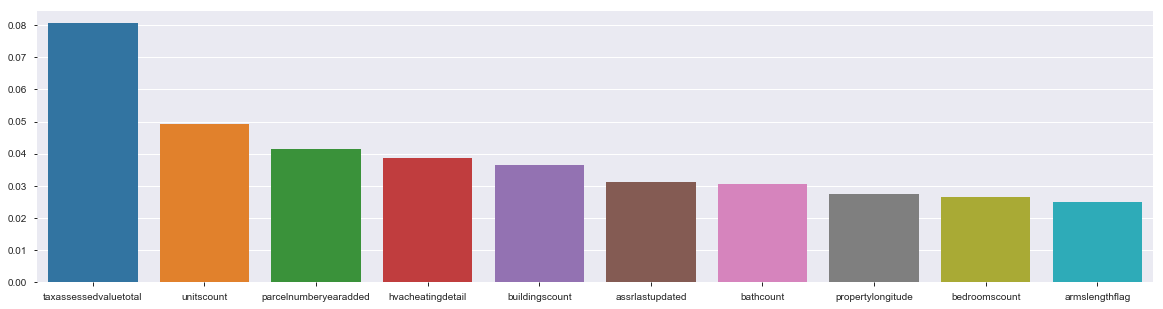

In [1158]:
sns.barplot(actual_cols[0:10], actual_features[:10])

### Feature importance via mutual information

As a comparison point to the 'feature_importance' function found in the XGBoost library, we can use the mutual informationa. We need to ensure that we have labelled discrete features correctly.
In order to do so, we need to create a boolean mask. We could also have used the categorical features that we generated in pre-processing the data as a mask.

In [1293]:
results_complete = results3.copy()
discrete_mask = np.zeros(shape=results3.shape[1], dtype=np.int32)
for feature in results3.columns:
    if len(results3[feature].unique()) <= 30 or 'date' in feature or 'year' in feature:
        discrete_mask[results3.columns.get_loc(feature)]=1

In [1289]:
mi = mutual_info_classif(results_complete, target, discrete_features=discrete_mask)
# sort the features along with their names into the most important features
features_with_cols = list(zip(mi, results_complete.columns))
sorted_features = sorted(features_with_cols, key=lambda x: x[0], reverse=True)
array_features = np.array(sorted_features)
from operator import itemgetter
actual_cols = list(map(itemgetter(1), array_features))
actual_features = list(map(itemgetter(0), array_features))
actual_features = list(map(float, actual_features))

It is interesting to note the lack of intersection between the features found to be important via the mutual information metric and via the 'feature_importance' functionality found in the XGBoost library.
The output of the cell below showing just the top ten most important features are quite different to the output 

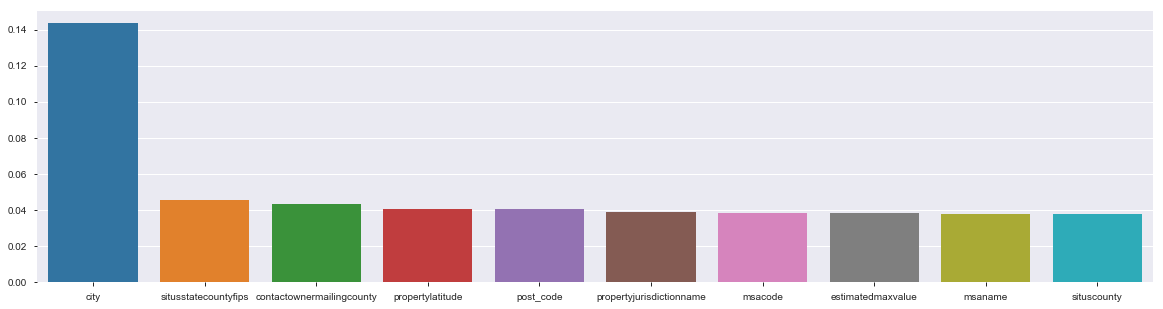

In [1292]:
sns.barplot(actual_cols[0:10], actual_features[:10])

In [1166]:
import pandas_profiling as pf
profile = results_complete.profile_report()
rejected_variables = profile.get_rejected_variables(threshold=0.9)


In [1171]:
os.mkdir('Models')

In [1172]:
joblib.dump(vc, 'Models/voting_classifier')

['Models/voting_classifier']

In [1305]:
joblib.dump(best_fr, 'Models/tuned_forest')

['Models/tuned_forest']

## Unit Tests

In [82]:
import typing
from typing import List
def remove_dots_col(full_df: pd.DataFrame)->List[str]:
    '''
    This is a function that removes any columns before a '.' in a column name. Excepts a Pandas DataFrame
    i.e. input.attom_id->attom_id, attom_avm.post_code->postcode, etc
    >>> remove_dots_col(q.iloc[:, :5])
    ['attom_id', 'city', 'country', 'post_code', 'safety_flag']
    '''

    new_cols = []
    for col in full_df.columns.tolist():
        if len(col.split('.'))>=2:
            new_cols.append(col.split('.')[1])
        else:
            new_cols.append(col)
    #full_df.columns = new_cols
    # return full_df
    return new_cols
from keras.utils import to_categorical
q = pd.read_csv('data/inputs_enrich3.csv')
cleaned_data_cols = remove_dots_col(q)
q.columns = cleaned_data_cols
from sklearn.model_selection import train_test_split
q['safety_flag'] = np.where(q['safety_flag']==False,0,1)
x_tr, x_tr, y_tr, y_ts = train_test_split(q[q.columns.difference(['safety_flag'])], to_categorical(q['safety_flag']), random_state=1)
def one_hot_to_normal(Y_test: np.ndarray)->np.ndarray:
    '''
    This is a test to convert one-hot encoded data back to a label-encoded scheme of a single-dimensional 
    i.e. [[0,0], [0,1], [0,0]] becomes [0,1,0]:
    >>> one_hot_to_normal(y_ts[:5])
    [0, 0, 0, 1, 0]
    '''
    reverse_one_hot = []
    for lab in Y_test:
        for idx, elem in enumerate(lab):
            if elem == 1:
                reverse_one_hot.append(idx)
    return reverse_one_hot

import doctest
doctest.testmod(verbose=True)



Trying:
    add(2, 2)
Expecting:
    4
ok
Trying:
    one_hot_to_normal(y_ts[:5])
Expecting:
    [0, 0, 0, 1, 0]
ok
Trying:
    remove_dots_col(q.iloc[:, :5])
Expecting:
    ['attom_id', 'city', 'country', 'post_code', 'safety_flag']
ok
1 items had no tests:
    __main__
3 items passed all tests:
   1 tests in __main__.add
   1 tests in __main__.one_hot_to_normal
   1 tests in __main__.remove_dots_col
3 tests in 4 items.
3 passed and 0 failed.
Test passed.


TestResults(failed=0, attempted=3)

## Concluding Remarks

The feature evaluation metrics show that the location of the city, as well as properties such as the assessed market value and number of buildings present in the area are strongly predictive of 'safety_flag'. This suggests that high density areas are correlated with the safety of the area.
We could have also performed more feature elimination by removing highly correlated features. For example, the 'propertylatitude' and 'post_code' features would presumably by highly correlated (for example, using the in-built 'corr' function present in the Pandas API).
Using a fair metric i.e. the balanced recall showed that a hyper-parameter tuned Random Forest was the best-performing 
classification model. The MLP (using Keras) could have possibly rivalled this model had there been more time present for fine-tuning the model i.e. using multiple hidden layers, changing the number of neurons present, using different activation functions or using different metrics to evaluate the performance of the model.
The ensembled Voting Classifier also performed quite well in comparison to other models. This model could have been improved had more time been spent investigating better combinations of base classifiers, as well as using different voting strategies i.e. 'soft-voting versus hard-voting'.
The stacking classifier also could have performed better had more time been spent on investigating different combinations of base classifiers as well as the 'meta-classifier'.
Addtional steps that could have been taken would have been exploring different imputation strategies as well as different scaling strategies. 
The DemystData API was quite intuitive to use in terms of identifying different data sets to help enrich the preliminary data